In [1]:
import os
from datetime import datetime
import json
import logging

from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
from csbdeep.utils import axes_dict, plot_history, plot_some

from matplotlib import pyplot as plt
import tensorflow as tf
import tf2onnx
import onnx
import numpy as np

import mlflow
from mlflow.models import infer_signature
from mlflow.pyfunc import log_model as pyfunc_log_model
from mlflow.onnx import log_model as onnx_log_model

from flame.error import CAREInferenceError
from flame.utils import _compress_dict_fields, set_up_tracking_server, get_windows_user_path

2025-07-26 11:30:25.482405: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 11:30:25.499212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753554625.507262 4109362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753554625.509613 4109362 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753554625.515873 4109362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.run_functions_eagerly(False)

In [3]:
WINDOWS_USER_PATH = get_windows_user_path()

In [ ]:
logger = logging.getLogger("MAIN")
logging.basicConfig(
    filename=os.path.join(WINDOWS_USER_PATH, "logs", f"{datetime.now().strftime('%Y%m%d-%H%M%S')}_training_CARE.log"),
    encoding="utf-8",
    level=logging.DEBUG
)

In [4]:
mlflow_logger = logging.getLogger("MLFLOW")

In [5]:
DATA_DIREC = "/mnt/d/data/processed/20250618_224I_denoising_5to40F"
PATCH_CONFIG_JSON = os.path.join(DATA_DIREC, "1Chan_patch_config.json")
SAVE_DIREC = "/mnt/d/models/"
UNET_KERN_SIZE = 3
TRAIN_BATCH_SIZE = 16
INFER_BATCH_SIZE = 1
RANDOM_STATE = 8888

MLFLOW_SERVER_IP = "127.0.0.1"
MLFLOW_SERVER_PORT = "5050"
MLFLOW_ARTIFACT_PATH = f"http://{MLFLOW_SERVER_IP}:{MLFLOW_SERVER_PORT}"

In [6]:
# ensure that data directory and patch config json paths are valid
assert os.path.isdir(DATA_DIREC)
assert os.path.isfile(PATCH_CONFIG_JSON)

### Creating training config by building on patch_config

In [7]:
try:
    config_json = json.load(open(PATCH_CONFIG_JSON, 'r'))
    logger.info(f"Successfully loaded patch config from {PATCH_CONFIG_JSON}")
except Exception as e:
    logger.error(f"Could not load patch config json from {PATCH_CONFIG_JSON}.\nERROR: {e}")
    raise CAREInferenceError(f"Could not load patch config json from {PATCH_CONFIG_JSON}.\nERROR: {e}")

In [ ]:
server_process = set_up_tracking_server(
    ip=MLFLOW_SERVER_IP,
    port=MLFLOW_SERVER_PORT,
    direc=MLFLOW_ARTIFACT_PATH,
    log_path=os.path.join(WINDOWS_USER_PATH, "logs", f"{datetime.now().strftime('%Y%m%d-%H%M%S')}_training_mlflow_server.log")
)

In [ ]:
mlflow.set_tracking_uri(uri=f"http://{MLFLOW_SERVER_IP}:{MLFLOW_SERVER_PORT}")
EXPERIMENT_NAME = f"CARE Denoising {config_json["Patch_Config"]["patch_shape"][-1]} Channel"
mlflow_logger.info(f"Using experiment {EXPERIMENT_NAME}")
mlflow.set_experiment(EXPERIMENT_NAME)

In [ ]:
mlflow.start_run()
run = mlflow.active_run()
MLFLOW_RUN_ID = run.info.run_id
MLFLOW_RUN_NAME = run.info.run_name
mlflow_logger.info(f"Run {MLFLOW_RUN_NAME} (id {MLFLOW_RUN_ID}) started at {datetime.now().strftime('%Y%m%d-%H%M%S')}")
print(f"Run {MLFLOW_RUN_NAME} (id {MLFLOW_RUN_ID}) started at {datetime.now().strftime('%Y%m%d-%H%M%S')}")


Run caring-stag-178 (id e8710f9b0eef4bc4bb3bb34e91e71330) started at 20250726-105501


In [ ]:
try:
    MODEL_NAME = f"FLAME_CARE_" \
        + f"{config_json['FLAME_Dataset']['input']['n_frames']}" \
        + f"to" \
        + f"{config_json["FLAME_Dataset"]['output']['n_frames']}F"
    logger.info(f"Training a model with NAME: '{MODEL_NAME}'...")
except Exception as e:
    logger.error(f"Failed to dynamically load model name.\nERROR: {e}")
    raise CAREInferenceError(f"Failed to dynamically load model name.\nERROR: {e}")


In [ ]:
try:
    MODEL_DIREC = os.path.join(SAVE_DIREC, MODEL_NAME, str(MLFLOW_RUN_ID))
    # exist_ok being True *SHOULD* (?) be fine because RUN_ID will not iterate upwards unless training either started or finished.
    os.makedirs(MODEL_DIREC, exist_ok = True)
    logger.info(f"Training run id is {MLFLOW_RUN_ID}.")
    logger.info(f"Model saving to {MODEL_DIREC}")
except Exception as e:
    logger.error(f"Failed to load run id and/or set up model save directory.\nERROR: {e}")
    raise CAREInferenceError(f"Failed to load run id and/or set up model save directory.\nERROR: {e}")

In [ ]:
config_json['Train_Config'] = {
    'npz_path': os.path.join(DATA_DIREC, config_json['Patch_Config']['npz_name']),
    'name': MODEL_NAME,
    'model_direc': MODEL_DIREC,
    'unet_kern_size': UNET_KERN_SIZE,
    'train_batch_size': TRAIN_BATCH_SIZE,
    'random_state': RANDOM_STATE,
}

In [ ]:
_compress_dict_fields(config_json)

{'FLAME_Dataset-name': '20250618_224I_denoising_5to40F',
 'FLAME_Dataset-type': 'denoising',
 'FLAME_Dataset-image_shapes': [[1, 3, 1200, 1200], [1, 3, 1200, 1196]],
 'FLAME_Dataset-input-n_frames': 5,
 'FLAME_Dataset-input-pixel_mean': 378.72098887921106,
 'FLAME_Dataset-input-pixel_min': 0,
 'FLAME_Dataset-input-pixel_max': 28400,
 'FLAME_Dataset-input-pixel_p1pct': [0.0, 0.0, 0.0],
 'FLAME_Dataset-input-pixel_1pct': [0.0, 0.0, 0.0],
 'FLAME_Dataset-input-pixel_5pct': [0.0, 0.0, 0.0],
 'FLAME_Dataset-input-pixel_95pct': [832.0, 1000.0, 1400.0],
 'FLAME_Dataset-input-pixel_99pct': [1400.0, 1800.0, 2200.0],
 'FLAME_Dataset-input-pixel_99p9pct': [2400.0, 3141.0, 4165.0],
 'FLAME_Dataset-input-pixel_std': 420.2389718127719,
 'FLAME_Dataset-output-n_frames': 40,
 'FLAME_Dataset-output-pixel_mean': 3022.801186980542,
 'FLAME_Dataset-output-pixel_min': 0,
 'FLAME_Dataset-output-pixel_max': 206600,
 'FLAME_Dataset-output-pixel_p1pct': [0.0, 0.0, 0.0],
 'FLAME_Dataset-output-pixel_1pct': [0.0

In [ ]:
# verifying npz path...
NPZ_PATH = config_json['Train_Config']['npz_path']
assert os.path.isfile(config_json['Train_Config']['npz_path']), f"NPZ path {NPZ_PATH} is not a file"

### Training and Validation Data

In [ ]:
(X, Y), (X_val, Y_val), axes = load_training_data(
    NPZ_PATH,
    validation_split=0.1,
    verbose=True
)

number of training images:	 8726
number of validation images:	 970
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


In [ ]:
c = axes_dict(axes)['C']
channels_in, channels_out = X.shape[c], Y.shape[c]

### CARE Model

In [ ]:
config_json['CARE_Model'] = {
    'name': MODEL_NAME,
    'experiment_name': EXPERIMENT_NAME,
    'run_id': MLFLOW_RUN_ID,
    'run_name': MLFLOW_RUN_NAME,
    'base_dir': SAVE_DIREC,
    'run_dir': MODEL_DIREC
}
config_json['CARE_Model']['CSBDeep_Config'] = {
    'axes': axes,
    'n_channel_in': channels_in,
    'n_channel_out': channels_out,
    'probabilistic': False, # default from CSBDeep
    'allow_new_parameters': False, # default from CSBDeep
    'unet_kern_size': UNET_KERN_SIZE,
    'train_batch_size': TRAIN_BATCH_SIZE,
    'unet_input_shape': tuple(config_json['Patch_Config']['patch_shape']),
    'allow_new_parameters': True
}

In [ ]:
config = Config(
    **config_json['CARE_Model']['CSBDeep_Config']
)

config_json['CARE_Model']['Model_Arch'] = vars(config)

In [ ]:
JSON_CONFIG_PATH = os.path.join(MODEL_DIREC, "model_config.json")
json.dump(config_json, open(JSON_CONFIG_PATH, 'w+'))

### Training the Model

In [ ]:
model = CARE(
    config,
    str(MLFLOW_RUN_ID),
    basedir=os.path.join(SAVE_DIREC, MODEL_NAME)
)

/home/balulab/miniconda3/envs/care/lib/python3.12/site-packages/csbdeep/models/base_model.py:203: UserWarning: output path for model already exists, files may be overwritten: /mnt/d/models/FLAME_CARE_5to40F/e8710f9b0eef4bc4bb3bb34e91e71330
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
I0000 00:00:1753552511.801969 4100213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
history = model.train(X, Y, validation_data=(X_val, Y_val), epochs=1)

I0000 00:00:1753552515.855670 4100882 service.cc:152] XLA service 0x7f9650007e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753552515.855700 4100882 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-26 10:55:15.891635: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753552516.131973 4100882 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753552518.871148 4100882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0615 - mae: 0.0615 - mse: 0.0073

/home/balulab/miniconda3/envs/care/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input
Received: inputs=('Tensor(shape=(1, 128, 128, 1))',)
  warnings.warn(msg)


400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0614 - mae: 0.0614 - mse: 0.0073 - val_loss: 0.0496 - val_mae: 0.0496 - val_mse: 0.0044 - learning_rate: 4.0000e-04

Loading network weights from 'weights_best.h5'.


In [ ]:
# model.keras_model.save(os.path.join(MODEL_DIREC, 'saved_model.keras'))

### Some quick visualizations

['learning_rate', 'loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


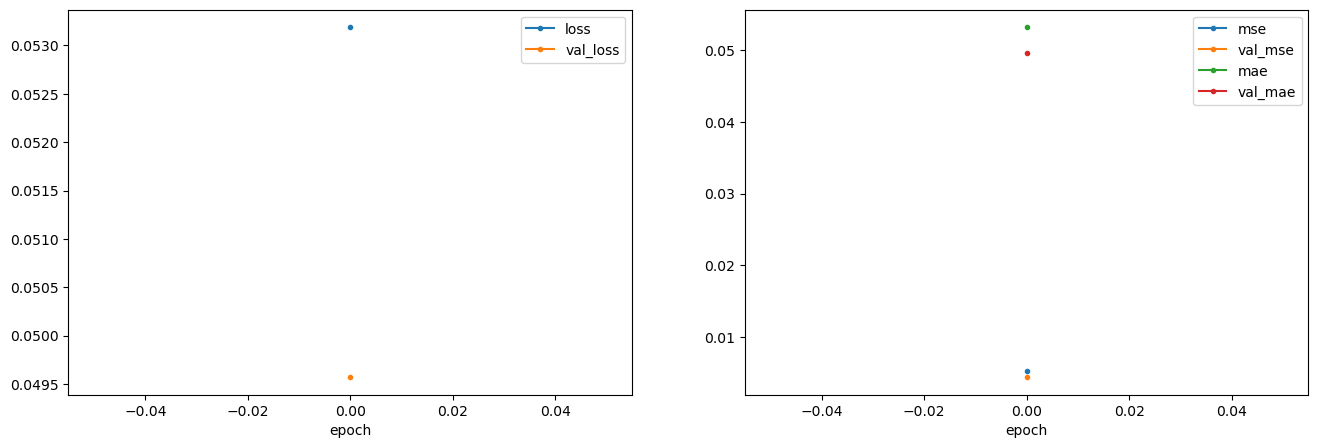

<Figure size 640x480 with 0 Axes>

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);
plt.savefig(os.path.join(MODEL_DIREC, "training_history.png"))

### Model Evaluation from Validation Set

In [ ]:
_P = model.keras_model.predict(X_val[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


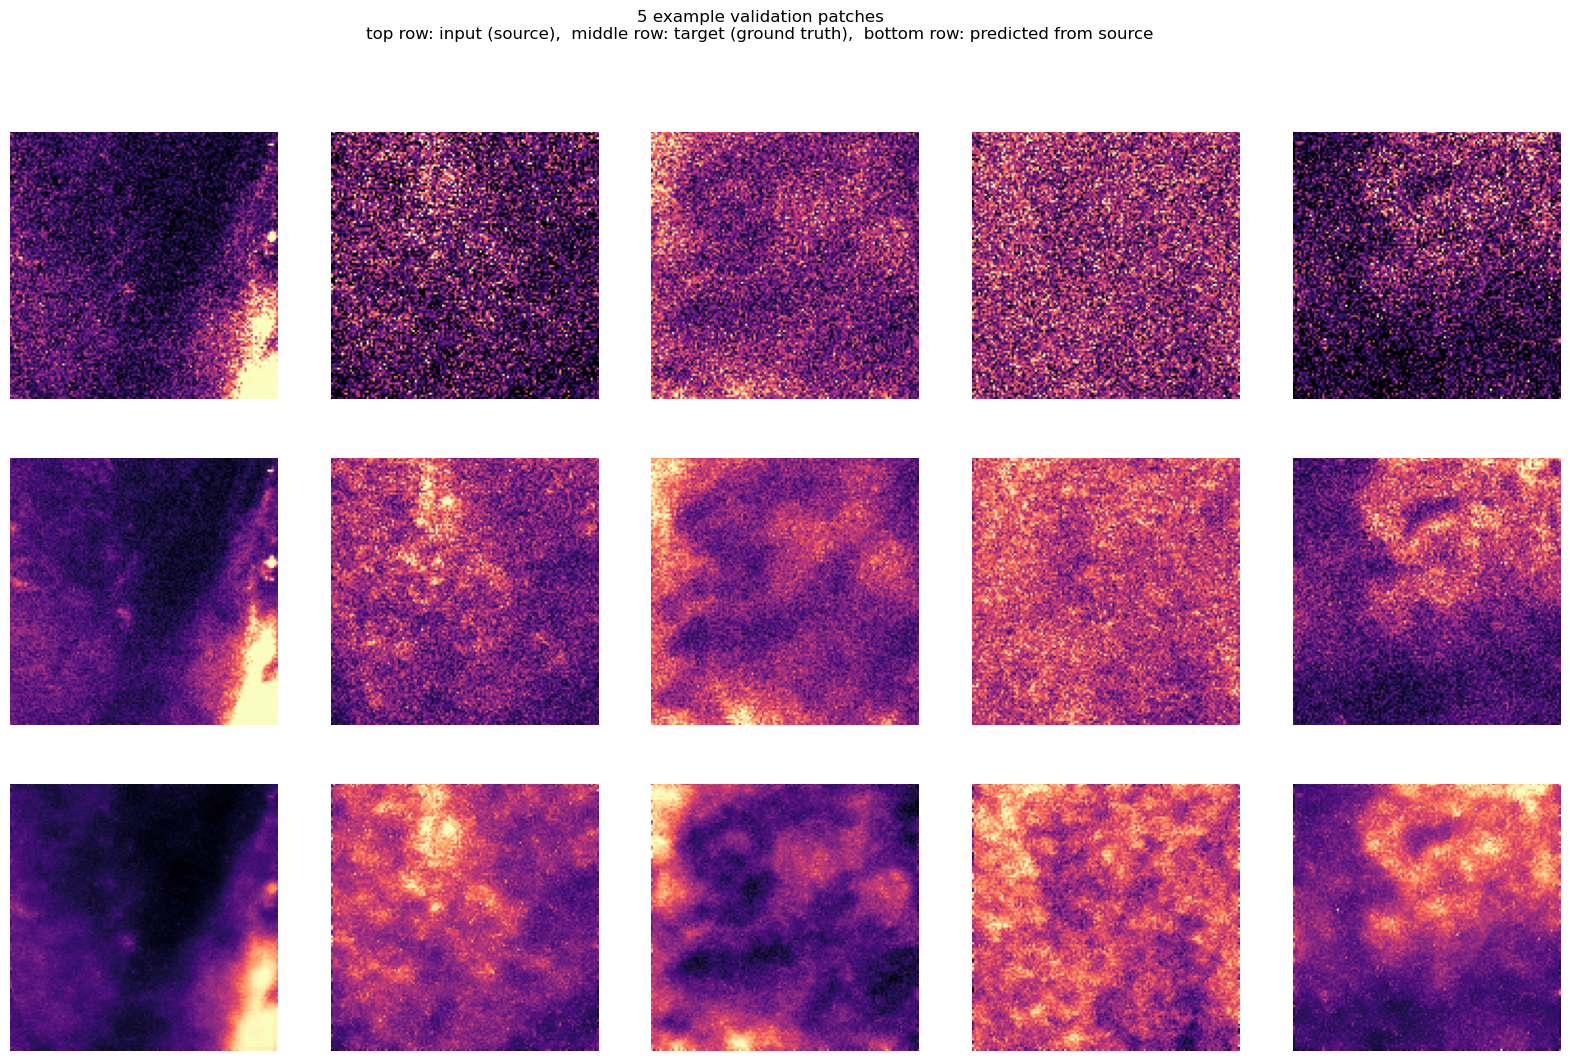

In [ ]:
plt.figure(figsize=(20,12))
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

plt.savefig(os.path.join(MODEL_DIREC, "val_set_predict_sample.png"))

### Logging Model in MLFlow Database

In [ ]:
val_loss = np.min(history.history['val_loss'])
idx = history.history['val_loss'].index(val_loss)
val_mae = history.history['val_mae'][idx]
val_mse = history.history['val_mse'][idx]

### Export to ONNX

In [ ]:
input_shape = list(X.shape)
batch_dim = axes_dict(axes)['S']
input_shape[batch_dim] = None
print(input_shape)

[None, 128, 128, 1]


In [ ]:
input_signature = [
    tf.TensorSpec(
        input_shape, 
        tf.float32, 
        name='patch'
    )
]

In [ ]:
onnx_model, _ = tf2onnx.convert.from_keras(
    model.keras_model,
    input_signature,
    opset=13
)

I0000 00:00:1753552527.798287 4100213 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753552527.798541 4100213 single_machine.cc:374] Starting new session
I0000 00:00:1753552527.798885 4100213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1753552528.146853 4100213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1753552528.203223 4100213 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753552528.203386 4100213 single_machine.cc:374] Starting new session
I0000 00:00:1753552528.203799 4100213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GP

In [ ]:
ONNX_PATH = os.path.join(MODEL_DIREC, f"{MODEL_NAME}.onnx")
onnx.save(onnx_model, ONNX_PATH)

In [ ]:
from flame.engine import CAREInferenceSession

In [ ]:
engine = CAREInferenceSession(
    model_path=ONNX_PATH,
    model_config_path=JSON_CONFIG_PATH,
    dataset_config_path=JSON_CONFIG_PATH
)

In [ ]:
X.shape

(8726, 128, 128, 1)

In [ ]:
# Log the hyperparameters
mlflow.log_params(_compress_dict_fields(config_json))

# Log the validation performance metrics
mlflow.log_metric("val_loss", np.min(val_loss))
mlflow.log_metric("val_mae", np.min(val_mae))
mlflow.log_metric("val_mse", np.min(val_mse))

model_info = onnx_log_model(
    onnx_model=onnx_model,
    artifact_path="model",
    conda_env=os.path.join(os.getcwd(), "environment_wsl.yml"),
    input_example=X[[0],...],

    # If given, create a model version under registered_model_name, 
    # also creating a registered model if one with the given name does not exist.
    # registered_model_name=_,

    metadata=config_json,
    signature=infer_signature(X[[0],...], engine.predict(X[[0],...])),
    onnx_execution_providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)

2025/07/26 10:55:42 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - matplotlib (current: 3.10.0, required: matplotlib==3.10.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/07/26 10:55:42 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - matplotlib (current: 3.10.0, required: matplotlib==3.10.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


InvalidUrlException: Invalid url: http:\\127.0.0.1:5050\859033271774544446/e8710f9b0eef4bc4bb3bb34e91e71330/artifacts/model/be8ec3e4-6a49-11f0-b239-00155dee5b8f

In [ ]:
mlflow.log_artifacts(
    local_dir=os.path.join(os.getcwd(), 'flame'),
    artifact_path="flame"
)

mlflow.log_artifact(
    local_path=JSON_CONFIG_PATH,
    artifact_path="model_config"
)

InvalidUrlException: Invalid url: http:\\127.0.0.1:5050\859033271774544446/e8710f9b0eef4bc4bb3bb34e91e71330/artifacts/flame/engine.py

In [ ]:
mlflow.end_run()

🏃 View run bright-chimp-367 at: http://127.0.0.1:5050/#/experiments/859033271774544446/runs/183bde81dc224807a2381ecba281d765
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/859033271774544446
